# CartPole-v0

Ref: https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

In [1]:
# !sudo cp /opt/conda/lib/libpython3.9.so.1.0 /usr/lib

In [2]:
!python --version

Python 3.8.10


In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.7.0'

In [5]:
import tf_agents
tf_agents.__version__

'0.11.0'

In [6]:
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.networks import sequential
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.dqn import dqn_agent
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.drivers import py_driver
from tf_agents.policies import py_tf_eager_policy

import matplotlib
import matplotlib.pyplot as plt

import reverb

import tensorflow as tf
import pyvirtualdisplay


import PIL
import numpy as np
import IPython
import imageio
import base64

In [7]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


In [8]:
num_iterations = 20000

learning_rate = 1e-4
num_eval_episodes = 10
replay_buffer_max_length = 100000
initial_collect_steps = 100
batch_size = 64
collect_steps_per_iteration = 1

log_interval = 200
eval_interval = 1000

## Environment

In [9]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

In [10]:
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.02613745, -0.02241037, -0.0004048 ,  0.02523139], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [11]:
frame = env.render(mode='rgb_array')

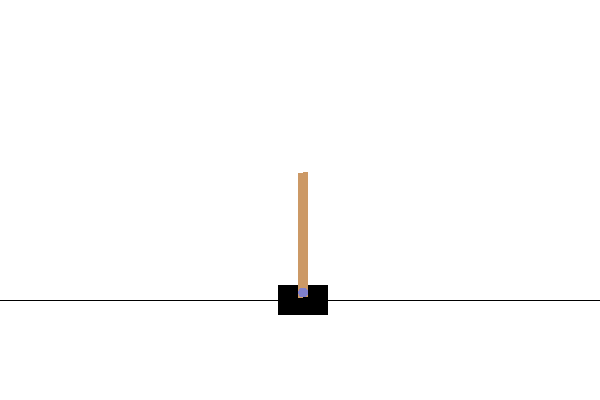

In [12]:
PIL.Image.fromarray(frame)

In [13]:
print('Time Step Spec:')
print(env.time_step_spec())

Time Step Spec:
TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})


In [14]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [ ]:
time_step = env.reset()
time_step


In [ ]:
action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
next_time_step

In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

In [ ]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

In [ ]:
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))

In [ ]:
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]

In [ ]:
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

In [ ]:
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policy

In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

### Random Policy Example

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [ ]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

In [ ]:
time_step = example_environment.reset()

In [ ]:
# for _ in range(100):
#     action = random_policy.action(time_step)
    
#     time_step = example_environment.step(action)
    
#     print(time_step.is_last(), time_step.reward, action)

## Metrics and Evaluation

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):
    
    total_return = 0.0
    for _ in range(num_episodes):
        
        time_step = environment.reset()
        episode_return =0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            
        total_return += episode_return
        
    avg_return = total_return / num_episodes
    
    return avg_return.numpy()[0]

In [ ]:
compute_avg_return(example_environment, random_policy, num_eval_episodes)

## Replay Buffer

In [ ]:
table_name = 'uniform_table'

replay_buffer_signature = tensor_spec.from_spec(
    agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2) # Current and next observation.

In [ ]:
agent.collect_data_spec

In [ ]:
agent.collect_data_spec._fields

## Data Collection

In [ ]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

In [ ]:
# iter(replay_buffer.as_dataset()).next()

In [ ]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

In [ ]:
iterator = iter(dataset)
print(iterator)

In [ ]:
# iterator.next()

## Training the Agent

In [ ]:
try:
    %%time
except:
    pass

In [ ]:
agent.train = common.function(agent.train)

In [ ]:
agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

In [ ]:
returns

In [ ]:
time_step = train_py_env.reset()

In [ ]:
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

In [ ]:
for _ in range(num_iterations):
    time_step, _ = collect_driver.run(time_step)
    
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    
    step = agent.train_step_counter.numpy()
    
    if step % log_interval == 0:
        print(f'step = {step}: loss = {train_loss}')
        
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print(f'step = {step}: Average Return = {avg_return}')
        returns.append(avg_return)
        

In [ ]:
iterations = range(0, len(returns) * eval_interval, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [ ]:
plt.show()

## Video

In [ ]:
def embed_mp4(filename):
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    
    tag = '''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + '.mp4'
    print('#1')
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            print('#2')
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render(mode='rgb_array'))
            while not time_step.is_last():
                print('#3')
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render(mode='rgb_array'))
                
    # return embed_mp4(filename)

In [ ]:
# create_policy_eval_video(agent.policy, 'trained-agent',num_episodes=1)
# create_policy_eval_video(random_policy, 'trained-agent',num_episodes=1)

In [ ]:
policy = agent.policy
filename = 'trained-agent' + policy.name
fps = 30
num_episodes = 5

In [ ]:
random_policy.name

In [ ]:
filename = filename + '.mp4'
print('#1')
with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
        print('#2')
        time_step = eval_env.reset()
        video.append_data(eval_py_env.render(mode='rgb_array'))
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = eval_env.step(action_step.action)
            video.append_data(eval_py_env.render(mode='rgb_array'))

In [ ]:
embed_mp4(filename)